In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Thu Aug 20 15:47:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=9a8ccd06d3fc6bf6959acc5a3a8b723692b9bfaaba2ffe30328f7876afddaed2
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [5]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 25.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [6]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [7]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [8]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

 10%|█         | 26/250 [00:00<00:00, 252.14it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 237.39it/s]

(250, 224, 224, 3) (250,)


In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [10]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [11]:
resnet_simclr = tf.keras.models.load_model('../input/simclr-vanilla/resnet_simclr1.h5')
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [12]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [13]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [14]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [15]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 128) (250, 128)


In [16]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/100
20/20 [==============================] - 0s 10ms/step - loss: 4.0434 - accuracy: 0.2312 - val_loss: 2.9643 - val_accuracy: 0.2320
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 2.3957 - accuracy: 0.2888 - val_loss: 1.9720 - val_accuracy: 0.3360
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 1.8474 - accuracy: 0.3384 - val_loss: 1.6355 - val_accuracy: 0.3880
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 1.6108 - accuracy: 0.3824 - val_loss: 1.4810 - val_accuracy: 0.3960
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 1.5035 - accuracy: 0.4120 - val_loss: 1.4124 - val_accuracy: 0.4240
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 1.4472 - accuracy: 0.4280 - val_loss: 1.3864 - val_accuracy: 0.4280
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 1.4095 - accuracy: 0.4232 - val_loss: 1.3404 - val_accuracy: 0.4640
Epoch 8/100


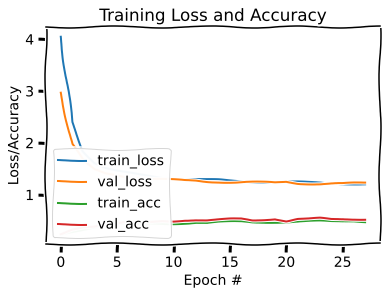

In [17]:
# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [18]:
# Encoder model with lesser non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 256) (250, 256)


Epoch 1/35
20/20 [==============================] - 0s 8ms/step - loss: 2.8761 - accuracy: 0.2744 - val_loss: 2.1053 - val_accuracy: 0.3360
Epoch 2/35
20/20 [==============================] - 0s 3ms/step - loss: 1.8508 - accuracy: 0.3752 - val_loss: 1.6031 - val_accuracy: 0.4520
Epoch 3/35
20/20 [==============================] - 0s 3ms/step - loss: 1.5647 - accuracy: 0.4176 - val_loss: 1.4332 - val_accuracy: 0.4680
Epoch 4/35
20/20 [==============================] - 0s 3ms/step - loss: 1.4423 - accuracy: 0.4520 - val_loss: 1.3540 - val_accuracy: 0.4640
Epoch 5/35
20/20 [==============================] - 0s 3ms/step - loss: 1.3759 - accuracy: 0.4528 - val_loss: 1.2974 - val_accuracy: 0.4560
Epoch 6/35
20/20 [==============================] - 0s 7ms/step - loss: 1.3369 - accuracy: 0.4624 - val_loss: 1.2890 - val_accuracy: 0.4640
Epoch 7/35
20/20 [==============================] - 0s 5ms/step - loss: 1.3169 - accuracy: 0.4680 - val_loss: 1.2490 - val_accuracy: 0.4800
Epoch 8/35
20/20 [==

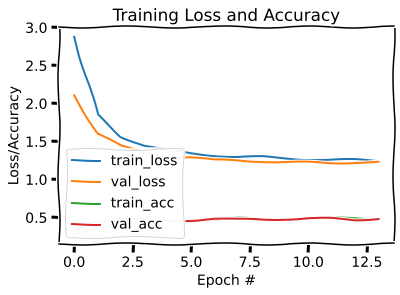

In [19]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [20]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 2048) (250, 2048)


Epoch 1/35
20/20 [==============================] - 0s 8ms/step - loss: 1.8002 - accuracy: 0.3080 - val_loss: 1.3479 - val_accuracy: 0.4440
Epoch 2/35
20/20 [==============================] - 0s 4ms/step - loss: 1.3322 - accuracy: 0.4536 - val_loss: 1.2721 - val_accuracy: 0.5000
Epoch 3/35
20/20 [==============================] - 0s 3ms/step - loss: 1.3344 - accuracy: 0.4368 - val_loss: 1.1964 - val_accuracy: 0.5000
Epoch 4/35
20/20 [==============================] - 0s 3ms/step - loss: 1.2831 - accuracy: 0.4720 - val_loss: 1.3424 - val_accuracy: 0.4840
Epoch 5/35
20/20 [==============================] - 0s 3ms/step - loss: 1.2610 - accuracy: 0.4848 - val_loss: 1.1885 - val_accuracy: 0.5160
Epoch 6/35
20/20 [==============================] - 0s 3ms/step - loss: 1.2104 - accuracy: 0.4960 - val_loss: 1.2537 - val_accuracy: 0.5400
Epoch 7/35
20/20 [==============================] - 0s 3ms/step - loss: 1.2573 - accuracy: 0.4888 - val_loss: 1.3056 - val_accuracy: 0.5240
Epoch 00007: early s

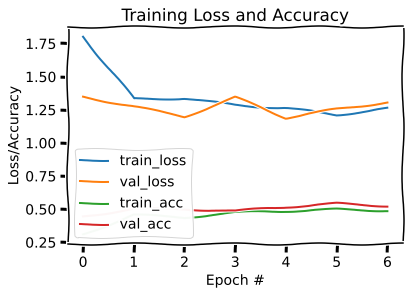

In [21]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)